In [ ]:
# testing pretrained model
# %pip install torch torchvision matplotlib
# %pip install lime

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets
from torchvision.models import resnet50, densenet121
from torch.utils.data import random_split, DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
import numpy as np
import os

In [2]:
# image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# load the datasets
dataset_path = './dataset'
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = full_dataset.classes
print(f'Classes: {class_names}')

Classes: ['battery', 'cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'syringe', 'trash']


In [3]:
# split dataset into train and test
# train_size = int(0.8 * len(full_dataset))
# test_size = len(full_dataset) - train_size
# train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

labels = [label for _, label in full_dataset]
labels = np.array(labels)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in splitter.split(np.zeros(len(labels)), labels):
    train_dataset = Subset(full_dataset, train_idx)
    test_dataset = Subset(full_dataset, test_idx)

print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of testing samples: {len(test_dataset)}')

Number of training samples: 3410
Number of testing samples: 853


In [4]:
# data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# loading Densenet121 (pretrained model for transfer learning)
model = models.densenet121(weights="DEFAULT")

for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last dense block
for param in model.features.denseblock4.parameters():
    param.requires_grad = True

num_classes = len(class_names)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(model.classifier.in_features, num_classes)
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

cuda


In [6]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [7]:
# Training loop
import datetime
epochs = 50
print("Training started...")

loss_trace = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"{datetime.datetime.now().time()} Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")
    loss_trace.append(running_loss/len(train_loader))

print("Training complete.")

Training started...
17:30:18.924103 Epoch 1/50, Loss: 0.7503
17:30:57.522325 Epoch 2/50, Loss: 0.4139
17:31:35.785078 Epoch 3/50, Loss: 0.3243
17:32:14.078292 Epoch 4/50, Loss: 0.2358
17:32:52.524251 Epoch 5/50, Loss: 0.1895
17:33:30.946375 Epoch 6/50, Loss: 0.1553
17:34:09.445863 Epoch 7/50, Loss: 0.1241
17:34:47.647537 Epoch 8/50, Loss: 0.1314
17:35:25.873807 Epoch 9/50, Loss: 0.1032
17:36:04.345401 Epoch 10/50, Loss: 0.1097
17:36:42.543906 Epoch 11/50, Loss: 0.0858
17:37:21.051525 Epoch 12/50, Loss: 0.0745
17:37:59.071724 Epoch 13/50, Loss: 0.0866
17:38:37.603838 Epoch 14/50, Loss: 0.0517
17:39:16.206175 Epoch 15/50, Loss: 0.0483
17:39:54.515930 Epoch 16/50, Loss: 0.0530
17:40:33.061647 Epoch 17/50, Loss: 0.0966
17:41:11.580964 Epoch 18/50, Loss: 0.0719
17:41:50.185703 Epoch 19/50, Loss: 0.0574
17:42:28.947722 Epoch 20/50, Loss: 0.0345
17:43:07.539385 Epoch 21/50, Loss: 0.0460
17:43:45.655643 Epoch 22/50, Loss: 0.0532
17:44:24.327717 Epoch 23/50, Loss: 0.0630
17:45:02.699111 Epoch 2

In [ ]:
# # Prepare Stratified K-Fold Cross-Validation
# K = 5  # Number of folds
# skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
# indices = np.arange(len(full_dataset))
# targets = np.array([full_dataset.targets[i] for i in range(len(full_dataset))])

# # Training parameters
# batch_size = 32
# epochs = 5  # Adjust based on training time

# # Store performance metrics
# fold_accuracies = []
# fold_f1_scores = []

# # K-Fold Cross-Validation loop
# for fold, (train_idx, val_idx) in enumerate(skf.split(indices, targets)):
#     print(f"\nFold {fold + 1}/{K}")

#     # Create train and validation subsets
#     train_subset = Subset(full_dataset, train_idx)
#     val_subset = Subset(full_dataset, val_idx)

#     # Create data loaders
#     train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

#     # Load ResNet50 model
#     model = models.resnet50(pretrained=True)
#     for param in model.parameters():
#         param.requires_grad = False  # Freeze pretrained layers

#     # Modify fully connected layer with dropout
#     model.fc = nn.Sequential(
#         nn.Dropout(p=0.1),
#         nn.Linear(model.fc.in_features, num_classes)
#     )

#     model = model.to(device)

#     # Loss function and optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

#     # Training loop
#     for epoch in range(epochs):
#         model.train()
#         running_loss = 0.0
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()

#         print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

#     # Validation loop
#     model.eval()
#     correct, total = 0, 0
#     true_labels, predicted_labels = [], []

#     with torch.no_grad():
#         for images, labels in val_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs, 1)

#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#             true_labels.extend(labels.cpu().numpy())
#             predicted_labels.extend(predicted.cpu().numpy())

#     # Calculate metrics
#     accuracy = 100 * correct / total
#     fscore = f1_score(true_labels, predicted_labels, average='macro')

#     fold_accuracies.append(accuracy)
#     fold_f1_scores.append(fscore)

#     print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}%")
#     print(f"Fold {fold + 1} F1-Score: {fscore:.4f}")

# # Print final K-Fold results
# print("\nFinal Cross-Validation Results:")
# print(f"Average Accuracy: {np.mean(fold_accuracies):.2f}% ± {np.std(fold_accuracies):.2f}")
# print(f"Average F1-Score: {np.mean(fold_f1_scores):.4f} ± {np.std(fold_f1_scores):.4f}")

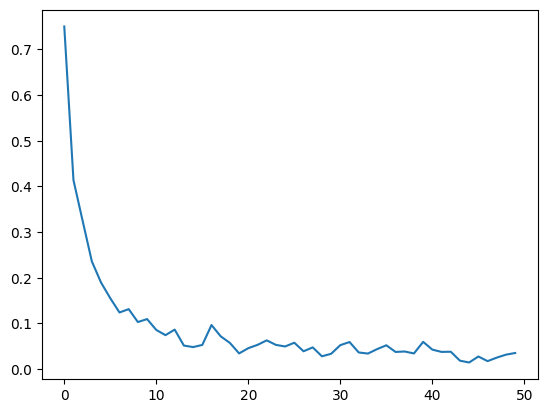

In [8]:
plt.plot(loss_trace)

In [9]:
# Validation
model.eval()
correct = 0
total = 0
true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f'Testing Accuracy: {accuracy:.2f}%')

# Calculate F1-Score (Macro for Multi-class)
fscore = f1_score(true_labels, predicted_labels, average='micro')
print(f'F1-Score: {fscore:.4f}')

# Save model
torch.save(model.state_dict(), 'densenet121_model2-nobg.pth')
print("Model saved.")

Testing Accuracy: 90.15%
F1-Score: 0.9015
Model saved.


In [ ]:
import scikitplot as skplt
from sklearn.metrics import classification_report

skplt.metrics.plot_confusion_matrix(true_labels, predicted_labels)
print(classification_report(true_labels, predicted_labels, target_names=['battery', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'syringe', 'trash']))